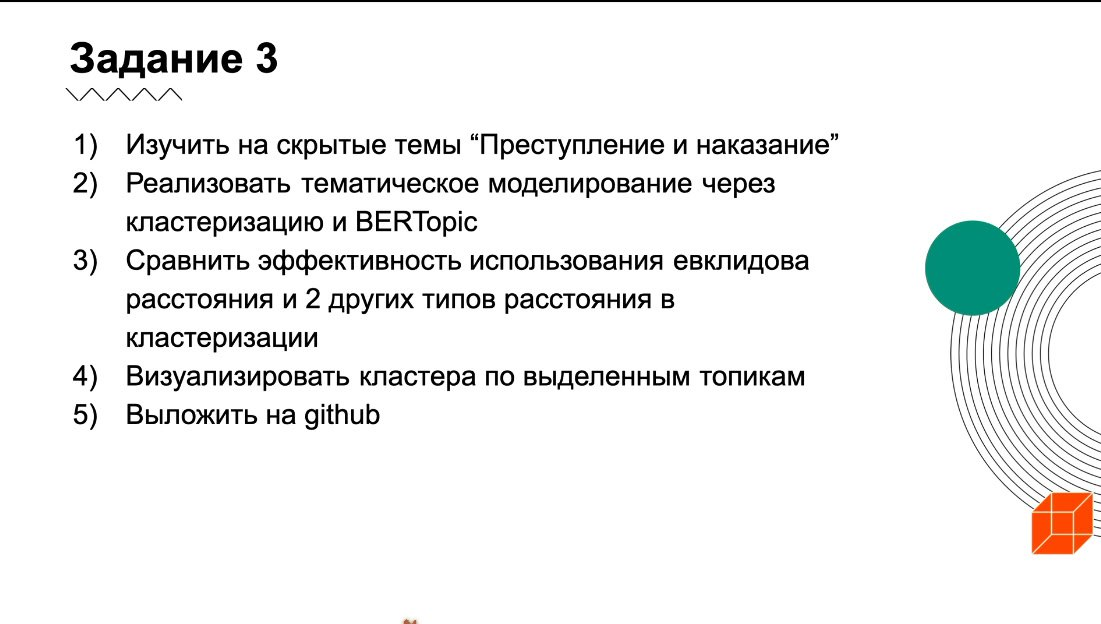

In [1]:
!pip install pymorphy2-dicts-ru
!pip install pymorphy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=8724ae472aeba0865cf6203a002107a0d9c726376b1d57cc5c89df4c1444ac8b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
from google.colab import files

import re
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm
import pymorphy2

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
uploaded = files.upload()

Saving Crime And Punishment.txt to Crime And Punishment.txt


#Делим текст на документы и создаем датасет

In [5]:
with open('/content/Crime And Punishment.txt', 'r', encoding='utf-8') as file:
    text = file.read()

roman_numerals_pattern = r'(\n{4}(?:I{1,3}|IV|V{1,3}|VI{1,3}|VII{1,3}|VIII|IX|X{1,3})\n{4})'

sections = re.split(roman_numerals_pattern, text)

sections = [section.strip() for section in sections if section.strip()]

df = pd.DataFrame(sections, columns=['Text'])

output_file = '/content/Crime_And_Punishment_Sections.csv'
df.to_csv(output_file, index=False)

df.head(), output_file

(                                                Text
 0  Annotation\n\n\n«Преступление и наказание» – г...
 1                                                  I
 2  В начале июля, в чрезвычайно жаркое время, под...
 3                                                 II
 4  Раскольников не привык к толпе и, как уже сказ...,
 '/content/Crime_And_Punishment_Sections.csv')

Я решил разделить текст по частям, которые разделены римскими цифрами

#Обработка датасета

Уберем строки с римскими цифрами и первую строку, т.к. там находится аннотация к тексту


In [6]:
df = df.iloc[1:]
df = df[~df['Text'].str.match(r'^(?:I{1,3}|IV|V{1,3}|VI{1,3}|VII{1,3}|VIII|IX|X{1,3})$')]
df.reset_index(drop=True, inplace=True)
df.head()

,Text
0,"В начале июля, в чрезвычайно жаркое время, под..."
1,"Раскольников не привык к толпе и, как уже сказ..."
2,"Он проснулся на другой день уже поздно, после ..."
3,Письмо матери его измучило. Но относительно гл...
4,"«Действительно, я у Разумихина недавно еще хот..."


Пойдем по стандартному пути с приведением текста к нижнему регистру, удалением пунктуации и специальных символов, токенизацией текста, удалением стоп-слов и лемматизацией

In [7]:
morph = pymorphy2.MorphAnalyzer()
stop_words_rus = set(stopwords.words('russian'))

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [morph.parse(word)[0].normal_form for word in tokens if word not in stop_words_rus]
    text = ' '.join(tokens)
    return text

In [9]:
tqdm.pandas(desc="Preprocessing documents")
df['preprocessed_text'] = df['Text'].progress_apply(preprocess_text)

Preprocessing documents: 100%|██████████| 41/41 [00:13<00:00,  2.94it/s]


In [10]:
df.head()

,Text,preprocessed_text
0,"В начале июля, в чрезвычайно жаркое время, под...",начало июль чрезвычайно жаркое время вечер мол...
1,"Раскольников не привык к толпе и, как уже сказ...",раскольник привыкнуть толпа сказать бежать вся...
2,"Он проснулся на другой день уже поздно, после ...",проснуться день поздно тревожный сон сон подкр...
3,Письмо матери его измучило. Но относительно гл...,письмо мать измучить относительно главный капи...
4,"«Действительно, я у Разумихина недавно еще хот...",действительно разумихин недавно хотеть работа ...


In [11]:
del df["Text"]
df

,preprocessed_text
0,начало июль чрезвычайно жаркое время вечер мол...
1,раскольник привыкнуть толпа сказать бежать вся...
2,проснуться день поздно тревожный сон сон подкр...
3,письмо мать измучить относительно главный капи...
4,действительно разумихин недавно хотеть работа ...
5,впоследствии раскольников случиться узнать име...
6,дверь отвориться крошечный щёлочка вострый нед...
7,пролежать очень долго случаться просыпаться ми...
8,обыск застать комната никто никто заглядывать ...
9,однако беспамятство время болезнь это лихорадо...


#Начинаем работу с BertTopic

##Скачиваем и импортируем все необходимое

In [12]:
!pip install bertopic

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [13]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [14]:
data = df['preprocessed_text']

Преобразовываем текст в эмбеддинги

Настраиваем модели с нашими тремя метриками- косинусное расстояние, манхэттенское расстояние и евклидово расстояние

In [101]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
embeddings = model.encode(data.tolist(), show_progress_bar=True)

umap_model_cosine = UMAP(n_neighbors=5, n_components=5, metric='cosine')
hdbscan_euclidean = HDBSCAN(min_cluster_size=3, metric='euclidean')
hdbscan_manhattan = HDBSCAN(min_cluster_size=3, metric='manhattan')

def create_and_fit_bertopic(cluster_model, umap_model, embeddings, data):
    reduced_embeddings = umap_model.fit_transform(embeddings)
    if reduced_embeddings.size == 0:
        raise ValueError("Reduced embeddings are empty. Cannot proceed with BERTopic modeling.")
    topic_model = BERTopic(language="russian")
    topics, probs = topic_model.fit_transform(data, reduced_embeddings)
    return topic_model, topics, probs

def calculate_silhouette(embeddings, labels):
    unique_labels = set(labels)
    if len(unique_labels) > 1:
        return silhouette_score(embeddings, labels)
    else:
        return None

def visualize_topics_if_possible(topic_model, name):
    if len(topic_model.get_topic_info()) > 0:
        fig = topic_model.visualize_topics()
        fig.show()
    else:
        print(f"No topics to visualize for {name}")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [105]:

topic_model_euclidean, topics_euclidean, probs_euclidean = create_and_fit_bertopic(hdbscan_euclidean, umap_model_cosine, embeddings, data)
print("Темы с HDBSCAN (евклидово расстояние):", topic_model_euclidean.get_topic_info())
silhouette_euclidean = calculate_silhouette(embeddings, topics_euclidean)
if silhouette_euclidean:
    print("Силуэтный коэффициент (евклидово расстояние):", silhouette_euclidean)
else:
    print("Недостаточно кластеров для вычисления силуэтного коэффициента (евклидово расстояние)")



topic_model_cosine, topics_cosine, probs_cosine = create_and_fit_bertopic(hdbscan_euclidean, umap_model_cosine, embeddings, data)
print("Темы с HDBSCAN (косинусное расстояние):", topic_model_cosine.get_topic_info())
silhouette_cosine = calculate_silhouette(embeddings, topics_cosine)
print("Силуэтный коэффициент (косинусное расстояние):", silhouette_cosine)

topic_model_manhattan, topics_manhattan, probs_manhattan = create_and_fit_bertopic(hdbscan_manhattan, umap_model_cosine, embeddings, data)
print("Темы с HDBSCAN (манхэттенское расстояние):", topic_model_manhattan.get_topic_info())
silhouette_manhattan = calculate_silhouette(embeddings, topics_manhattan)
print("Силуэтный коэффициент (манхэттенское расстояние):", silhouette_manhattan)


Темы с HDBSCAN (евклидово расстояние):    Topic  Count                         Name  \
0     -1      3     -1_это_мочь_авдотья_свой   
1      0     21  0_это_раскольник_знать_один   
2      1     17     1_это_соня_знать_сказать   

                                      Representation  \
0  [это, мочь, авдотья, свой, романович, говорить...   
1  [это, раскольник, знать, один, свой, говорить,...   
2  [это, соня, знать, сказать, иванович, петрович...   

                                 Representative_Docs  
0  [раскольник приподняться сесть диван слабо мах...  
1  [посреди улица стоять коляска щегольский барск...  
2  [восемь час оба спешить бакалеев прийти ранний...  
Силуэтный коэффициент (евклидово расстояние): 0.009989469
Темы с HDBSCAN (косинусное расстояние):    Topic  Count                         Name  \
0      0     21  0_это_раскольник_знать_один   
1      1     20     1_это_знать_сказать_свой   

                                      Representation  \
0  [это, раскольник, зна

#Визуализация тем